In [1]:
#https://ravivaishnav20.medium.com/visualizing-feature-maps-using-pytorch-12a48cd1e573
import torch
import numpy as np
import os
import sys
sys.path.append('../')
os.environ["CUDA_VISIBLE_DEVICES"]="5"
import torchvision
from voc import *
from coco import *
import torchvision.transforms as transforms
# from torchvision.models import resnet152, resnet101, resnet18, resnet34, resnet50
from tqdm import tqdm
import json
import pandas as pd
import matplotlib.pyplot as plt
from config import seed_everything
seed_everything(0)
from models import *
from torchsummary import summary

import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms, utils
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
from PIL import Image
import json
%matplotlib inline

/home/seongha/anaconda3/envs/MGSSL/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
image_normalization_mean = [0.485, 0.456, 0.406]
image_normalization_std = [0.229, 0.224, 0.225]
normalize = transforms.Normalize(mean=image_normalization_mean,
                                             std=image_normalization_std)
transform = transforms.Compose([
                # MultiScaleCrop(self.state['image_size'], scales=(1.0, 0.875, 0.75, 0.66, 0.5), max_distort=2),
                # transforms.RandomHorizontalFlip(),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                # normalize,
            ])

In [2]:
from models import *
from backbones.config import config
print(config)
for k, v in config.items():
  print("{} : {}".format(k, v))

m_li = [base_resnet50(model_path=config['resnet50'], num_classes=80, pretrained=True),\
   base_vit(config['vit'], 80, image_size=224, pretrained=True),\
      base_swin(config['swin'], 80, image_size=224, pretrained=True, requires_grad=True),\
         base_convnext(config['convnext'], 80, image_size=224, pretrained=True), \
           base_mlpmixer(config['mlpmixer'], num_classes=80, image_size=224, pretrained=True)]
# m_li2 = [BaseResnet(m_li[0], 80)]
p_li = ['/home/seongha/LT-ML/checkpoint/coco/coco_LT(0)_label_cnt_in21k-4-4-0_resnet50_base_best.pth.tar', \
  '/home/seongha/LT-ML/checkpoint/coco/coco_LT(0)_label_cnt_in21k-4-4-0_vit_base_best.pth.tar', \
    '/home/seongha/LT-ML/checkpoint/coco/coco_LT(0)_label_cnt_in22k-4-4-0_swin_base_best.pth.tar',\
  '/home/seongha/LT-ML/checkpoint/coco/coco_LT(0)_label_cnt_in22k-4-4-0_convnext_base_best.pth.tar',\
      '/home/seongha/LT-ML/checkpoint/coco/coco_LT(0)_label_cnt_in21k-4-4-0_mlpmixer_base_best.pth.tar' ,\
  ]

def get_model(index):
  path = p_li[index]
  model = m_li[index]
  di = torch.load(path)
  print(di['best_score'])
  print(di.keys())
  model.load_state_dict(di['state_dict'])
  return model

model = get_model(2)
print(model)
# summary(model.features, (3,224,224), None)

{'resnet50': 'resnetv2_50x3_bitm_in21k', 'vit': 'vit_base_patch16_224_in21k', 'vit-hybrid': 'vit_base_r50_s16_224_in21k', 'swin': 'swin_base_patch4_window7_224_in22k', 'convnext': 'convnext_base_in22k', 'mlpmixer': 'mixer_b16_224_in21k'}
resnet50 : resnetv2_50x3_bitm_in21k
vit : vit_base_patch16_224_in21k
vit-hybrid : vit_base_r50_s16_224_in21k
swin : swin_base_patch4_window7_224_in22k
convnext : convnext_base_in22k
mlpmixer : mixer_b16_224_in21k
Linear(in_features=768, out_features=80, bias=True)


/home/seongha/anaconda3/envs/MGSSL/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


{'mAP': tensor(74.8108), 'OF1': 0.7193339297047961, 'CF1': 0.6759560773634149}
dict_keys(['epoch', 'arch', 'state_dict', 'best_score'])
BaseSwin(
  (features): Sequential(
    (0): PatchEmbed(
      (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (1): Dropout(p=0.0, inplace=False)
    (2): Sequential(
      (0): BasicLayer(
        (blocks): Sequential(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=128, out_features=384, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=128, out_features=128, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((128,), eps=1e-05, ele

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [5]:
from pytorch_tools.modules.weight_standartization import WS_Conv2d as StdConv2d



In [4]:

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import cv2
import numpy as np
import torch
import torchvision
from pytorch_grad_cam import AblationCAM, EigenCAM
from pytorch_grad_cam.ablation_layer import AblationLayerFasterRCNN
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget
from pytorch_grad_cam.utils.reshape_transforms import fasterrcnn_reshape_transform
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_accross_batch_and_channels, scale_cam_image

In [2]:
def predict(input_tensor, model, device, detection_threshold):
    outputs = model(input_tensor)
    pred_classes = [coco_names[i] for i in outputs[0]['labels'].cpu().numpy()]
    pred_labels = outputs[0]['labels'].cpu().numpy()
    pred_scores = outputs[0]['scores'].detach().cpu().numpy()
    pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    
    boxes, classes, labels, indices = [], [], [], []
    for index in range(len(pred_scores)):
        if pred_scores[index] >= detection_threshold:
            boxes.append(pred_bboxes[index].astype(np.int32))
            classes.append(pred_classes[index])
            labels.append(pred_labels[index])
            indices.append(index)
    boxes = np.int32(boxes)
    return boxes, classes, labels, indices

def draw_boxes(boxes, labels, classes, image):
    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
        cv2.putText(image, classes[i], (int(box[0]), int(box[1] - 5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return image

coco_names = ['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', \
              'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 
              'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 
              'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella',
              'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
              'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
              'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork',
              'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
              'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
              'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet',
              'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
              'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock', 'vase',
              'scissors', 'teddy bear', 'hair drier', 'toothbrush']


# This will help us create a different color for each class
COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3))

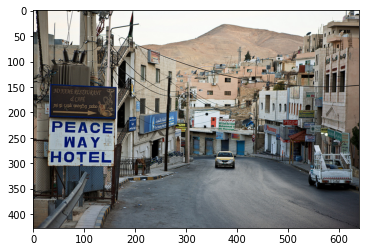

In [12]:
img_id = '/home/seongha/LT-ML/data/coco/data/train2014/COCO_train2014_000000000094.jpg'
image = Image.open(img_id)
plt.imshow(image)

image_float_np = np.float32(image) / 255
# define the torchvision image transforms

image_normalization_mean = [0.485, 0.456, 0.406]
image_normalization_std = [0.229, 0.224, 0.225]
normalize = transforms.Normalize(mean=image_normalization_mean,
                                             std=image_normalization_std)
transform = transforms.Compose([
                # MultiScaleCrop(self.state['image_size'], scales=(1.0, 0.875, 0.75, 0.66, 0.5), max_distort=2),
                # transforms.RandomHorizontalFlip(),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                # normalize,
            ])
# transform = torchvision.transforms.Compose([
#     torchvision.transforms.ToTensor(),
# ])

input_tensor = transform(image)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_tensor = input_tensor.to(device)
# Add a batch dimension:
input_tensor = input_tensor.unsqueeze(0)

# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# from torchvision.models import resnet50
# model = resnet50(pretrained=True)
# model.eval().to(device)

# # Run the model and display the detections
# boxes, classes, labels, indices = predict(input_tensor, model, device, 0.9)
# image = draw_boxes(boxes, labels, classes, image)

# # Show the image:
# Image.fromarray(image)


In [13]:
input_tensor.shape

torch.Size([1, 3, 224, 224])

In [15]:
print(target_layers)

[LayerNorm((1024,), eps=1e-05, elementwise_affine=True)]


In [16]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

layers = model.features[2]
target_layers=[layers[-1].blocks[-1].norm1]

cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)


# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

targets = [ClassifierOutputTarget(18)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

grayscale_cam = grayscale_cam[0, :, :]
visualization = show_cam_on_image(image_float_np, grayscale_cam, use_rgb=True)

Image.fromarray(visualization)

AxisError: axis 3 is out of bounds for array of dimension 3

In [28]:
from timm.models import swin_base_patch4_window7_224_in22k
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
def reshape_transform(tensor, height=7, width=7):
    result = tensor[:, 1 :  , :].reshape(tensor.size(0), 
        height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result
model = swin_base_patch4_window7_224_in22k(pretrained=True,num_classes = 80)
model.cuda()
target_layer = [model.layers[-1].blocks[-1].norm1]
# layers = model.features[2]
# target_layer=layers[-1].blocks[-1].norm1
cam = GradCAM(model=model, 
                      target_layers=target_layers, 
                      reshape_transform=reshape_transform)

# rgb_img = cv2.imread(img_id, 1)[:, :, ::-1]
rgb_img = np.array(Image.open(img_id))
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img = np.float32(rgb_img) / 255
input_tensor = preprocess_image(rgb_img, mean=image_normalization_mean, 
                                          std=image_normalization_std).cuda()
targets = [ClassifierOutputTarget(18)]
grayscale_cam = cam(input_tensor=input_tensor,
                    targets=targets,
                    eigen_smooth=True,
                    aug_smooth=True)

grayscale_cam = grayscale_cam[0, :]
cam_image = show_cam_on_image(rgb_img, grayscale_cam)
cv2.imwrite('save_path.jpg', cam_image)

AxisError: axis 2 is out of bounds for array of dimension 0